# Ex8 영화리뷰 텍스트 감성분석하기

## 필요 라이브러리 또는 모듈 입력

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import missingno as msno
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')



## 네이버 영화리뷰데이터 확인하기.

### 데이터 구성 확인

In [2]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


* train 데이터와 test 데이터의 컬럼은 같고 id, document, label이 있음을 확인할 수 있습니다.

### 결측치 확인

* mnno.matrix 메소드를 통해 결측치를 시각화 해봤습니다.

<AxesSubplot:>

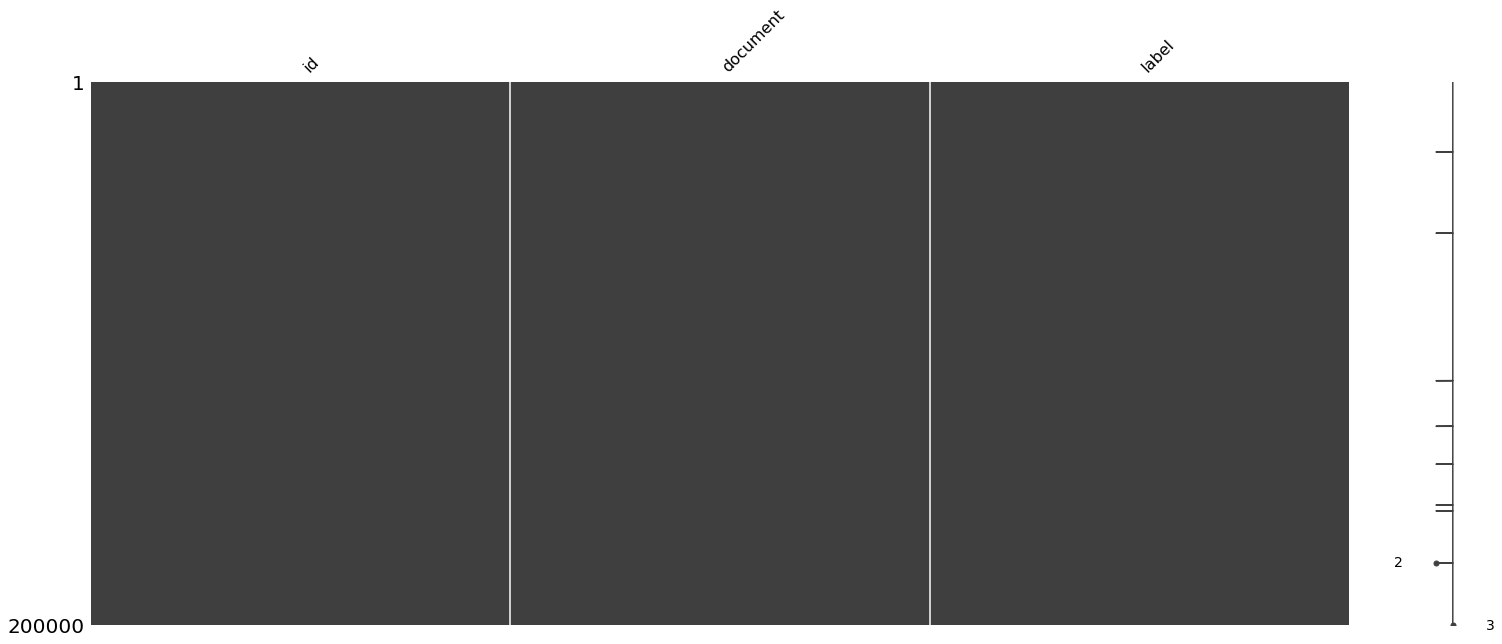

In [3]:
data = pd.concat((train_data, test_data), axis=0)
msno.matrix(data)

* 데이터가 많은 것에 비해 결측치의 양이 적어 눈으로 확인할 수 없었습니다. 그래서 pd.isnull 메소드를 통해 직접 확인해봤습니다.

In [4]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
document : 8
label : 0


* document에서 8개의 결측치가 있는 것을 확인하였습니다.

### 중복값 확인

* duplicated 함수를 통해 각열마다 id와 document 값의 중복값이 있는지 확인해 보겠습니다.

In [5]:
print(data.duplicated(["id"]).value_counts())
print(data.duplicated(["document"]).value_counts())

False    200000
dtype: int64
False    194544
True       5456
dtype: int64


* document에서 5456개의 중복값이 있는 것을 볼 수 있습니다.

In [6]:
raw=data['document'].tolist()

## 데이터 로더 구성을 통한 데이터 전처리

* drop_duplicates로 데이터의 중복 제거.
* dripna 로 결측치제거
* mecab을 활용한 한국어 토큰화
* 리스트 컴프리헨션을 활용한 불용어 제거
* word to index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환.

In [7]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

## 엔코더 디코더 함수 만들기

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 문장의 최대 길이 조절하기
* 처음에는 단어 갯수의 평균에서 2배의 표준편차를 더하여 최대길이를 설정해본 결과 전체문장의 93프로를 포함된다고 나왔습니다. 그래서 95프로 이상 포함하기위해 표준편차의 2.5배를 평균에서 더한 값을 길이의 최대값으로 결정했습니다.

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


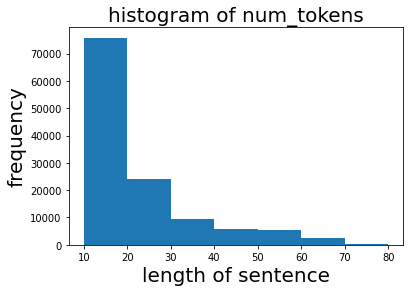

In [10]:
bins=[10,20,30,40,50,60,70,80]
plt.hist(num_tokens,bins=bins)
plt.title('histogram of num_tokens', fontsize=20)
plt.xlabel('length of sentence', fontsize=20)
plt.ylabel('frequency',fontsize=20)
plt.show()

* 문장길이의 히스토그램을 그려봤습니다. 위에 계산한것처럼 문장의 길이가 15인경우가 가장많았고 문장의 길이가 길어질수록 빈도수가 exponential하게 줄어듬을 볼 수 있습니다.

### 딕셔너리 가공 및 패딩하기
* 딕셔너리 앞에 관례적으로 pad, bos, unk, unused를 넣어준다.

In [11]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

* padding을 할때 풀잎스쿨에서 post는 뒤로갈 수록 feature가 희미해지는 현상이 생긴다고하여 rnn은 뒤의 데이터가 중요하다고하여 pre 패딩이 post 패딩보다 좋은 성능을 보인다고합니다. 그래서 pre로 설정했습니다.

In [12]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 48)


## 3가지 모델로 학습하기.

### LSTM 적용해보기.

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model.add(keras.layers.LSTM(8))# default로 activation은 tanh, rec activation은 sigmoid를 사용합니다.
model.add(keras.layers.Dense(8, activation = 'relu'))# 출력의 차원을 양의 정수로 받습니다.
model.add(keras.layers.Dense(1, activation = 'sigmoid'))# 최종 출력은 긍정(1) 혹은 부정(0)의 숫자로 sigmoid를 사용합니다.
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 훈련데이터와 검증데이터를 나눴습니다.

In [14]:
x_val = x_train[:10000]# 인덱싱을 활용하여 x__train의 10000건의 데이터를 분리합니다.
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]# 인덱싱을 활용하여 분리하고 남은 데이터를 x_train으로 사용합니다.
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 48)
(136182,)


### 콜벡 함수로 early stop을 적용하고 모델을 훈련시켰습니다.

In [15]:
model.compile(optimizer='adam',# optimizer는 Adam으로,
              loss='binary_crossentropy',#이진분류이기 때문에 binary_crossentrophy로,
              metrics=['accuracy'])# metric은 accuracy를 기준으로 학습합니다.
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    callbacks=[early_stop],
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 6s 13ms/step - loss: 0.5892 - accuracy: 0.6949 - val_loss: 0.3604 - val_accuracy: 0.8437
Epoch 2/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3429 - accuracy: 0.8575 - val_loss: 0.3398 - val_accuracy: 0.8524
Epoch 3/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3141 - accuracy: 0.8701 - val_loss: 0.3370 - val_accuracy: 0.8541
Epoch 4/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3017 - accuracy: 0.8765 - val_loss: 0.3379 - val_accuracy: 0.8532
Epoch 5/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2912 - accuracy: 0.8813 - val_loss: 0.3388 - val_accuracy: 0.8536
Epoch 6/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2850 - accuracy: 0.8828 - val_loss: 0.3389 - val_accuracy: 0.8536
Epoch 00006: early stopping


In [16]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 테스트 정확도가 0.848이 나왔습니다.

In [17]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3521 - accuracy: 0.8480
[0.3521021008491516, 0.8479768633842468]


### 훈련데이터와 검증데이터의 로스와 정확도에 대한 그래프를 그려봤습니다.

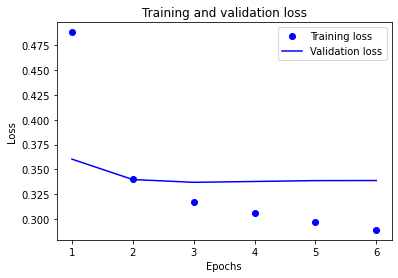

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

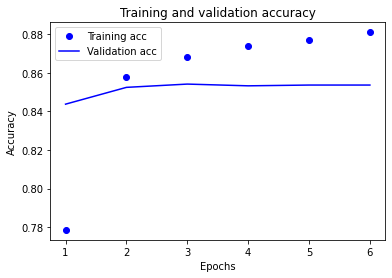

In [19]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1-D CNN 모델 적용하기

* 1D CNN도 하나의 적용할 수 있는 모델이기 때문에 적용해 봤습니다.

In [20]:
vocab_size2 = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim2 = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size2, word_vector_dim2, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

###  early stop을 적용하여 훈련했습니다.

In [22]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1)

history = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    callbacks=[early_stop],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 8s 21ms/step - loss: 0.5967 - accuracy: 0.6542 - val_loss: 0.3943 - val_accuracy: 0.8178
Epoch 2/20
266/266 [==============================] - 2s 9ms/step - loss: 0.3596 - accuracy: 0.8401 - val_loss: 0.3774 - val_accuracy: 0.8271
Epoch 3/20
266/266 [==============================] - 2s 9ms/step - loss: 0.3173 - accuracy: 0.8608 - val_loss: 0.3780 - val_accuracy: 0.8240
Epoch 4/20
266/266 [==============================] - 2s 9ms/step - loss: 0.2779 - accuracy: 0.8823 - val_loss: 0.3924 - val_accuracy: 0.8254
Epoch 5/20
266/266 [==============================] - 2s 9ms/step - loss: 0.2341 - accuracy: 0.9044 - val_loss: 0.4251 - val_accuracy: 0.8134
Epoch 00005: early stopping


### 테스트 정확도가 0.81로 결과가 LSTM보다 좋지 못했습니다.

In [23]:
results = model2.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4421 - accuracy: 0.8129
[0.4420726001262665, 0.8128648996353149]


### 훈련데이터와 검증데이터의 로스와 정확도에 대한 그래프를 그려봤습니다.

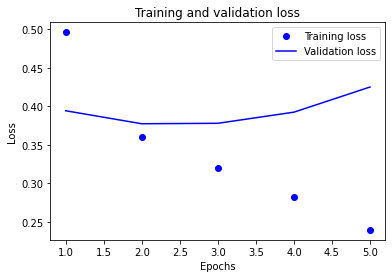

In [24]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

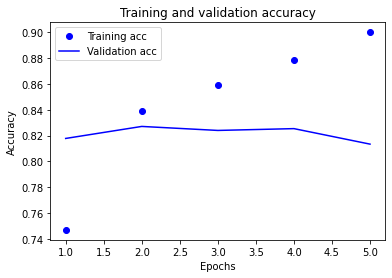

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### maxPooling 1layer 적용하기

* maxPooling도 적용해볼만한 하나의 모델이기 때문에 적용해봤습니다.

In [41]:
vocab_size3 = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim3 = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size3, word_vector_dim3, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [27]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### early stop을 적용하여 훈련했습니다.

In [28]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1)

history = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early_stop],
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 10ms/step - loss: 0.1937 - accuracy: 0.9230 - val_loss: 0.4557 - val_accuracy: 0.8187
Epoch 2/20
266/266 [==============================] - 2s 9ms/step - loss: 0.1551 - accuracy: 0.9386 - val_loss: 0.5132 - val_accuracy: 0.8153
Epoch 3/20
266/266 [==============================] - 2s 9ms/step - loss: 0.1303 - accuracy: 0.9491 - val_loss: 0.5725 - val_accuracy: 0.8109
Epoch 4/20
266/266 [==============================] - 2s 9ms/step - loss: 0.1109 - accuracy: 0.9566 - val_loss: 0.6346 - val_accuracy: 0.8036
Epoch 00004: early stopping


### 테스트 정확도가 0.7984로 다른모델들에비해 안좋았습니다.

In [29]:
results = model2.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6605 - accuracy: 0.7984
[0.6605461835861206, 0.7984417080879211]


### 훈련데이터와 검증데이터의 로스와 정확도에 대한 그래프를 그려봤습니다.

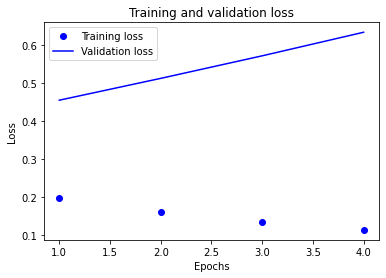

In [30]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

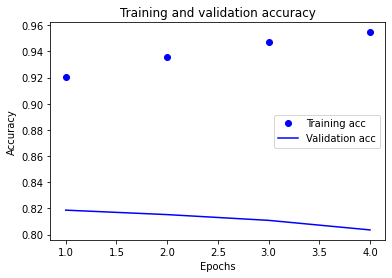

In [31]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## gensim의 유사단어 찾기를 활용한 임베딩 레이어 분석

### 학습된 임베딩레이어를 가져왔습니다.

In [32]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [33]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### 기존에 학습된 모델로 gensim을 활용해 사랑과 유사한 단어를 출력해봤습니다.

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

vector = word_vectors['사랑']
vector

array([-0.09000323,  0.12405784, -0.07397222,  0.06512106,  0.14286599,
        0.07866777, -0.05906132,  0.13709566, -0.08980451, -0.11728635,
       -0.0651167 ,  0.0686473 ,  0.05625439, -0.09282461,  0.09473711,
        0.07636973], dtype=float32)

### 따듯, 귀여움과 같은 몇몇단어는 사랑과 유사해보이지만 대부분의 단어는 상관없어보였습니다.

In [35]:
word_vectors.similar_by_word("사랑")

[('멋지', 0.9748193025588989),
 ('귀여움', 0.9746495485305786),
 ('박신양', 0.9743257761001587),
 ('놓치', 0.9738006591796875),
 ('개꿀', 0.9737414121627808),
 ('따뜻', 0.9718996286392212),
 ('어쨋든', 0.9717445373535156),
 ('따듯', 0.9716466665267944),
 ('명작', 0.97150719165802),
 ('어우러진', 0.9700005054473877)]

### 미리학습된 한국어 임베딩 데이터를 가져와서 gensim 유사단어찾기를 수행해봤습니다. 그결과 대부분의 단어가 사랑과 유사한 단어가 나옴을 볼 수 있었습니다.

In [36]:
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec=gensim.models.Word2Vec.load(word2vec_path)

vector = word2vec.wv.most_similar("사랑")
vector
#ord2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
#vector = word2vec['com']
#vector     # 무려 300dim의 워드 벡터입니다.

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

## Word2Vec을 활용하여 성능향상해보기

### 자체적 임베딩에서는 3가지모델을 적용해 봤을 때 LSTM 모델이 가장 좋은 테스트 정확도가 나와서 Word2Vec 기반 학습을 할때 LSTM을 적용했습니다.

In [37]:
from tensorflow.keras.initializers import Constant
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim =600  # 워드 벡터의 차원 수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8))# default로 activation은 tanh, rec activation은 sigmoid를 사용합니다.
model.add(keras.layers.Dense(8, activation = 'relu'))# 출력의 차원을 양의 정수로 받습니다.
model.add(keras.layers.Dense(1, activation = 'sigmoid'))# 최종 출력은 긍정(1) 혹은 부정(0)의 숫자로 sigmoid를 사용합니다.
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 600)           6000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 19488     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 6,019,569
Trainable params: 6,019,569
Non-trainable params: 0
_________________________________________________________________


### 과적합 방지를 위해 early stop을 적용하여 모델을 훈련했습니다.

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1)
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks=[early_stop],
                    validation_data=(x_val, y_val),
                    verbose=1)

###  최종 결과가 0.8521로 이전(0.84)에 비해 좋아짐을 볼수있습니다.

In [39]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3861 - accuracy: 0.8521
[0.3860599100589752, 0.8520861864089966]


### 회고
* 자체 임베딩을 하여 3가지 모델을 적용시켜본 결과 LSTM모델이 가장 좋은 성능을보였습니다. 그리고 가장 성능이 좋았던 LSTM 모델을 기반으로 word2vector를 적용시켜 85.2프로의 테스트 정확도를 갖도록 했습니다. 

* 성능을 개선하기 위해 여러가지 조치를 취했습니다.
1. 첫번째로는 문장의 최대길이를 설정할 때 최대 길이안에 95%이상이 들어가도록 최대길이 값을 높였습니다. 이전에는 데이터양이 많아서(정규분포에 가까워서 )평균+2시그마를 하면 됐었는데 데이터 량이적어서그런지 평균+ 2시그마를 해도 95프로 이하의 포함관계를 보였습니다. 그래서 평균+2.5시그마로 문장의 최대길이를 설정했습니다. 
2. 두번째로는 문장의 길이를 맞추기위해 padding을할 때 pre 패딩으로 설정했습니다. 왜냐하면 LSTM 같은 recurrent 모델은 문장의 단어들이 차례대로 입력이 들어가며, 마지막 단어가 입력으로 들어갈때는 앞 단어들의 시퀀스 모델링이 반영된 가장 중요한 상태라고 볼수있습니다. pre padding의 경우에는 앞단에 0이 채워져 제로 패딩이 입력으로 들어가는 일 없이 올바른 시퀀스 모델링이 진행되지만 반면에 post-padding은 뒷단에 0이 채워져 마지막 단어로 제로패딩이 입력 될 수 있습니다. 이러한 현상은 순차적인 모델에서 뒤로갈수록 특성이 희미해지는 long-dependency 현상을 심화시킬 수 있습니다. 따라서 pre padding이 poast padding 보다 recurrent 모델에서 더 좋은 성능을 보인다고 합니다.
3. 모델을 학습시킬 때 early stop기능 적용했습니다. 과도한 epoch는 모델이 훈련데이터를 지나치게 학습하게 되어 과적합이 일어날 수 있습니다. keras에서는 early stop기능을 제공하여 학습이 어느정도 학습이 완료됐을 경우 훈련을 정지시켜 과적합을 방지합니다. 이러한 기능을 제 모델에도 적용했습니다.
4. word2vector를 적용시키고 난 후에도 저는 테스트 정확도가 85프로가 넘지 않았습니다. 이때 하이퍼 파라미터인 단어의 차원을 높이니 테스트 정확도가 올라갔습니다. 왜그런가 생각해보니 단어의 차원은 단어를 얼마나 미세하게 표현할지를 의미합니다. 우리의 데이터의 양이 꽤 많으므로 단어의 차원을 높여 그만큼 미세하게 표현하는것이 성능에 유리하다고 생각합니다. 

* 이번 Ex를 통해 좀더 NLP에 가까워진 느낌이 들어 개인적으로 매우 유익했습니다. 이런 좋은 실습을 할 수 있게 해주셔서 감사합니다. 
